In [1]:
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# import markov_sim as markov
import json
import os
from datetime import datetime
from re import sub
from dateutil import  parser
import scipy
from sktime.transformations.series.outlier_detection import HampelFilter
from hampel import hampel

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['HSA_OVERRIDE_GFX_VERSION'] = '10.3.0'
os.environ['LD_LIBRARY_PATH'] = '$LD_LIBRARY_PATH:/opt/rocm-5.3.0/lib'
data_list = []


2023-04-18 08:53:30.162683: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:

for line in open('1.145414064.json', 'r'):
    data_list.append(json.loads(line))

runner_id = 2249834
runner_id_2 = 2251410
market_datetime = parser.parse(data_list[-1]['mc'][0]['marketDefinition']['marketTime'])
market_timestamp = datetime.timestamp(market_datetime) * 1000


def get_list(runner_id):
    # Create list for each runner
    runner_list = []
    for instance in data_list:
        if instance['pt'] > market_timestamp:
            if instance['mc'][0]['rc']:
                # Check for runner id
                temp_dict = {k: v for (k, v) in instance['mc'][0]['rc'][0].items() if v == runner_id}
                if temp_dict:
                    # Append runner info
                    runner_list.append([instance['mc'][0]['rc'][0], instance['pt']])
                elif len(instance['mc'][0]['rc']) > 1:
                    # If more than one runner
                    temp_dict_2 = {k: v for (k, v) in instance['mc'][0]['rc'][1].items() if v == runner_id}
                    if temp_dict_2:
                        runner_list.append([instance['mc'][0]['rc'][1], instance['pt']])
    return runner_list


def convert_odds(runner_list):
    # Convert to back/lay/last traded odds

    list = []

    for item in runner_list:
        if 'ltp' in item[0]:
            list.append([item[0]['ltp'], item[1]])

    del list[-1]
    arr = np.array(list)
    arr = arr[arr[:, 0] != 0]
    implied_odds = np.array([1 / arr[:, 0], arr[:, 1]]).T

    return implied_odds


# Find avg ltp odds
def odds_avg(runner_1, runner_2):
    if runner_1[-1, 1] > runner_2[-1, 1]:
        if runner_1[1, 1] > runner_2[1, 1]:
            timestamps = np.arange(round(runner_2[1, 1], -2), round(runner_1[-1, 1] + 1, -2), 100)
        else:
            timestamps = np.arange(round(runner_1[1, 1], -2), round(runner_1[-1, 1] + 1, -2), 100)
    else:
        if runner_1[1, 1] > runner_2[1, 1]:
            timestamps = np.arange(round(runner_2[1, 1], -2), round(runner_2[-1, 1] + 1, -2), 100)
        else:
            timestamps = np.arange(round(runner_1[1, 1], -2), round(runner_2[-1, 1] + 1, -2), 100)

    odds = np.zeros(np.shape(timestamps))
    df_timestamps = pd.Series(timestamps)
    df_datetime = pd.to_datetime(df_timestamps, unit='ms')

    df = pd.DataFrame({'runner 1': odds, '1 - runner 2': odds}, index=df_datetime)

    for index, time in enumerate(runner_1[:, 1]):
        df['runner 1'].loc[pd.to_datetime(round(time, -2), unit='ms')] = runner_1[index, 0]

    for index, time in enumerate(runner_2[:, 1]):
        df['1 - runner 2'].loc[pd.to_datetime(round(time, -2), unit='ms')] = 1 - runner_2[index, 0]

    df.replace(0, np.nan, inplace=True)
    df.interpolate(method='time', limit_direction='both', inplace=True)
    df['avg'] = df.mean(axis=1)
    df = df.resample('250ms').last()
    print(df)
    return df

def best_available(runner_list, start, end):

    back_list = []
    lay_list = []

    back_vol = []
    lay_vol = []

    df_datetime = pd.date_range(start, end, freq='100ms')

    for item in runner_list:
        if 'atb' in item[0]:
            if len(item[0]['atb']) > 1:
                temp = []
                for i in item[0]['atb']:
                    if i[1] != 0:
                        temp.append(i[0])
                if temp:
                    temp = np.array(temp)
                    back_list.append([temp.max(), item[1]])
                    back_vol.append(item[0]['atb'][temp.argmax()][1], item[1])
            else:
                if item[0]['atb'][0][1] != 0:
                    back_list.append([item[0]['atb'][0][0], item[1]])
                    back_vol.append(item[0]['atb'][0][1], item[1])

    for item in runner_list:
        if 'atl' in item[0]:
            if len(item[0]['atl']) > 1:
                temp = []
                for i in item[0]['atl']:
                    if i[1] != 0:
                        temp.append(i[0])
                if temp:
                    temp = np.array(temp)
                    lay_list.append([temp.min(), item[1]])
                    lay_vol.append(item[0]['atb'][temp.argmax()][1], item[1])
            else:
                if item[0]['atl'][0][1] != 0:
                    lay_list.append([item[0]['atl'][0][0], item[1]])
                    lay_vol.append(item[0]['atb'][0][1], item[1])

    del back_list[-1], lay_list[-1], back_vol[-1], lay_vol[-1]

    back_vol_arr = np.array(back_vol)
    lay_vol_arr = np.array(lay_vol)
    back_arr = np.array(back_list)
    lay_arr = np.array(lay_list)
    print(back_arr)

    back_series = pd.Series(back_arr[:, 0], index=pd.to_datetime(back_arr[:, 1], unit='ms'))
    lay_series = pd.Series(lay_arr[:, 0], index=pd.to_datetime(lay_arr[:, 1], unit='ms'))
    print(back_series)

    back_outliers = hampel(back_series, window_size=20)
    lay_outliers = hampel(lay_series, window_size=20)
    print(back_outliers)

    back_arr = np.delete(back_arr, back_outliers, axis=0)
    lay_arr = np.delete(lay_arr, lay_outliers, axis=0)
    back_vol_arr = np.delete(back_vol_arr, back_outliers, axis=0)
    lay_vol_arr = np.delete(lay_vol_arr, lay_outliers, axis=0)
    print(back_arr)

    df = pd.DataFrame({'back': np.zeros(df_datetime.shape), 'lay': np.zeros(df_datetime.shape)}, index=df_datetime)
    for index, time in enumerate(back_arr[:, 1]):
        df['back'].loc[pd.to_datetime(round(time, -2), unit='ms')] = back_arr[index, 0]
    for index, time in enumerate(lay_arr[:, 1]):
        df['lay'].loc[pd.to_datetime(round(time, -2), unit='ms')] = lay_arr[index, 0]
    df.replace(0, np.nan, inplace=True)
    df.interpolate(method='time', limit_direction='both', inplace=True)
    print(df)
    df_back = df['back'].resample('250ms').last().rolling('45S').mean()
    df_lay = df['lay'].resample('250ms').last().rolling('45S').mean()
    df = pd.concat([df_back, df_lay], axis=1)
    print(df)
    df = df.loc[start:end]
    df['back-lay avg'] = df.mean(axis=1)
    df['spread'] = df['lay'] - df['back']

    return df

def calc_pup(back_vol, lay_vol):
    pass

def calc_score():
    pass


def get_markov_odds():
    pass



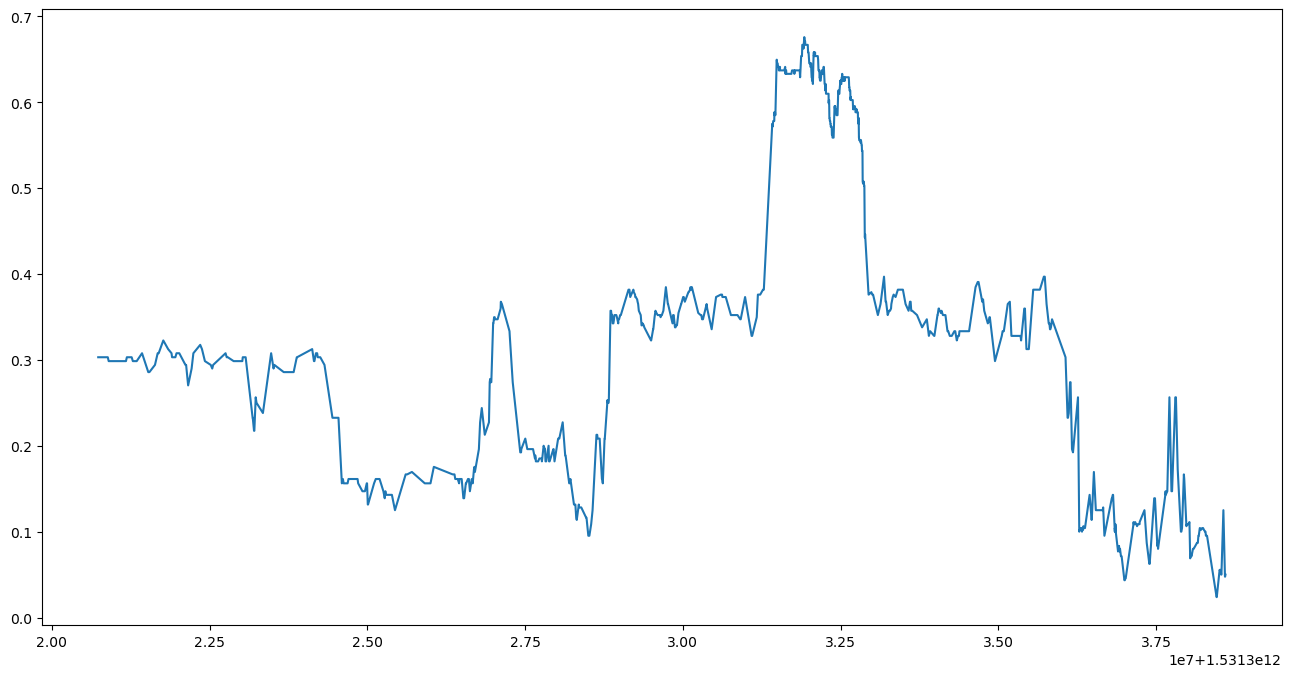

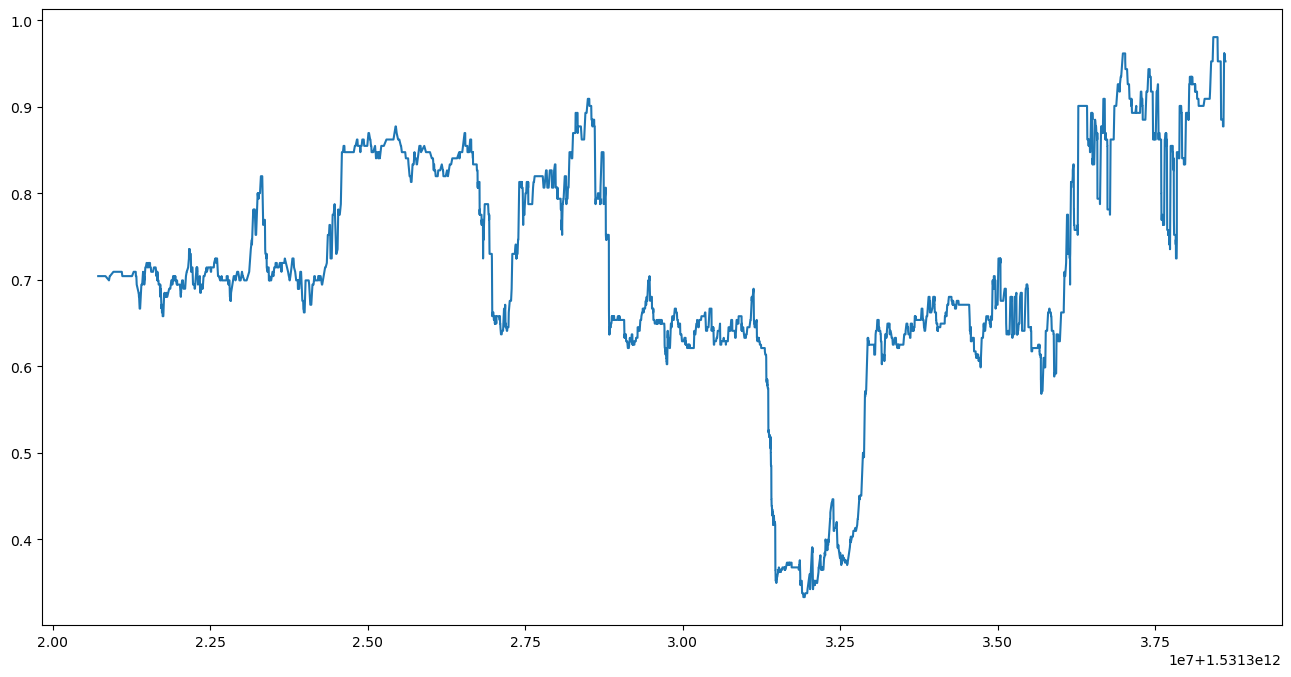

In [3]:
runner_list_1 = get_list(runner_id)
runner_list_2 = get_list(runner_id_2)
runner_odds_1 = convert_odds(runner_list_1)
runner_odds_2 = convert_odds(runner_list_2)
plt.figure(figsize=(16,8))
plt.plot(runner_odds_1[:, 1], runner_odds_1[:, 0])
plt.figure(figsize=(16,8))
plt.plot(runner_odds_2[:, 1], runner_odds_2[:, 0])


In [4]:
df = odds_avg(runner_odds_1, runner_odds_2)

                         runner 1  1 - runner 2       avg
2018-07-11 14:52:07.000   0.30303      0.295775  0.299402
2018-07-11 14:52:07.250   0.30303      0.295775  0.299402
2018-07-11 14:52:07.500   0.30303      0.295775  0.299402
2018-07-11 14:52:07.750   0.30303      0.295775  0.299402
2018-07-11 14:52:08.000   0.30303      0.295775  0.299402
...                           ...           ...       ...
2018-07-11 19:50:14.500   0.05000      0.047619  0.048810
2018-07-11 19:50:14.750   0.05000      0.047619  0.048810
2018-07-11 19:50:15.000   0.05000      0.047619  0.048810
2018-07-11 19:50:15.250   0.05000      0.047619  0.048810
2018-07-11 19:50:15.500   0.05000      0.047619  0.048810

[71555 rows x 3 columns]


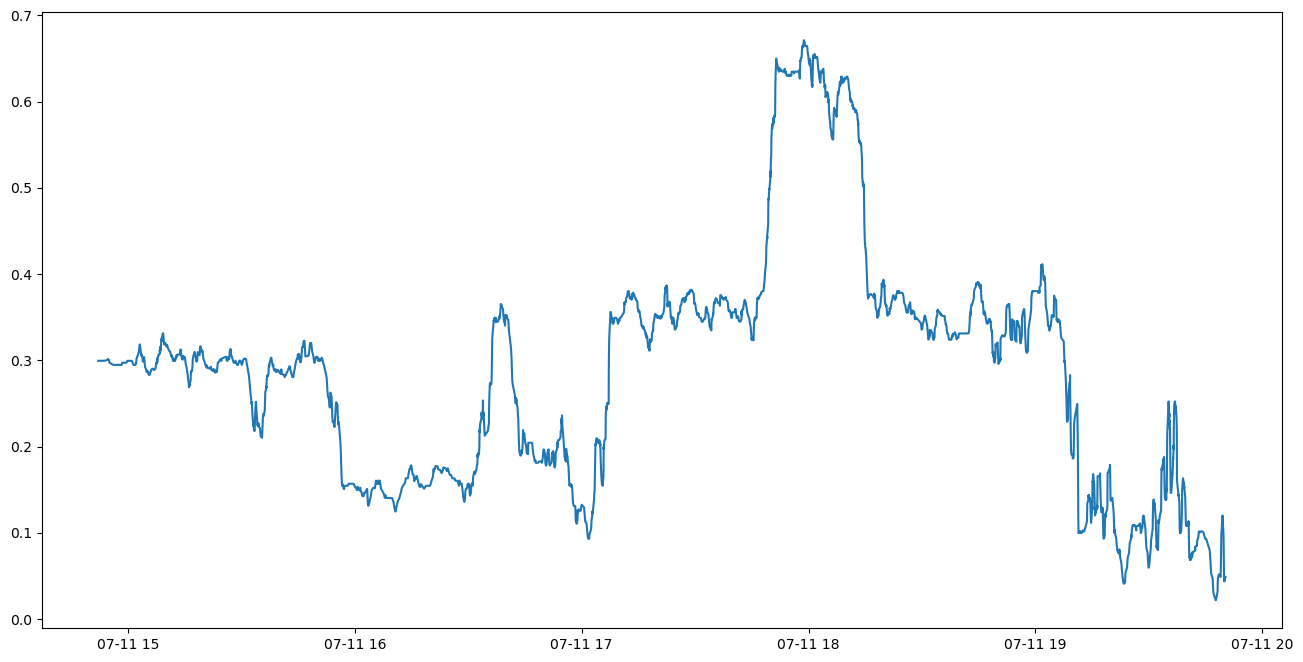

In [5]:
plt.figure(figsize=(16,8))
plt.plot(df['avg'])

In [6]:
start = df.first_valid_index()
end = df.last_valid_index()
runner_1_best = best_available(runner_list_1, start, end)
print(runner_1_best)

[[3.25000000e+00 1.53132074e+12]
 [3.15000000e+00 1.53132075e+12]
 [3.15000000e+00 1.53132075e+12]
 ...
 [4.00000000e+00 1.53133860e+12]
 [7.60000000e+00 1.53133860e+12]
 [8.40000000e+00 1.53133861e+12]]
2018-07-11 14:52:17.516000000     3.25
2018-07-11 14:52:29.844000000     3.15
2018-07-11 14:52:29.950000128     3.15
2018-07-11 14:52:35.651000064     3.15
2018-07-11 14:53:07.467000064     3.30
                                 ...  
2018-07-11 19:49:50.808999936    17.50
2018-07-11 19:49:58.233999872    20.00
2018-07-11 19:50:01.006000128     4.00
2018-07-11 19:50:02.496000000     7.60
2018-07-11 19:50:10.548000000     8.40
Length: 5467, dtype: float64
[20, 27, 44, 45, 47, 48, 51, 52, 53, 56, 58, 61, 63, 69, 81, 88, 111, 112, 175, 178, 179, 180, 201, 202, 203, 204, 207, 208, 209, 212, 214, 230, 231, 232, 267, 309, 322, 371, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 462, 463, 484, 488, 489, 497, 499, 500, 501, 507, 508, 509, 510, 514, 520, 571, 572, 573

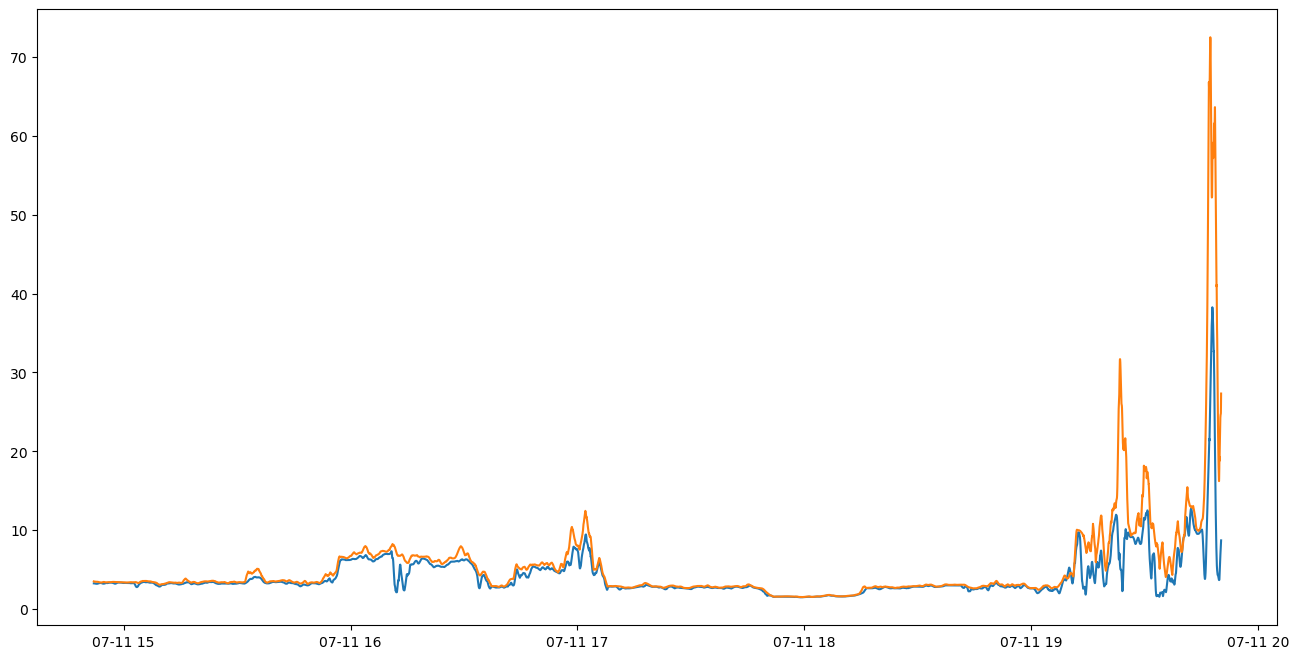

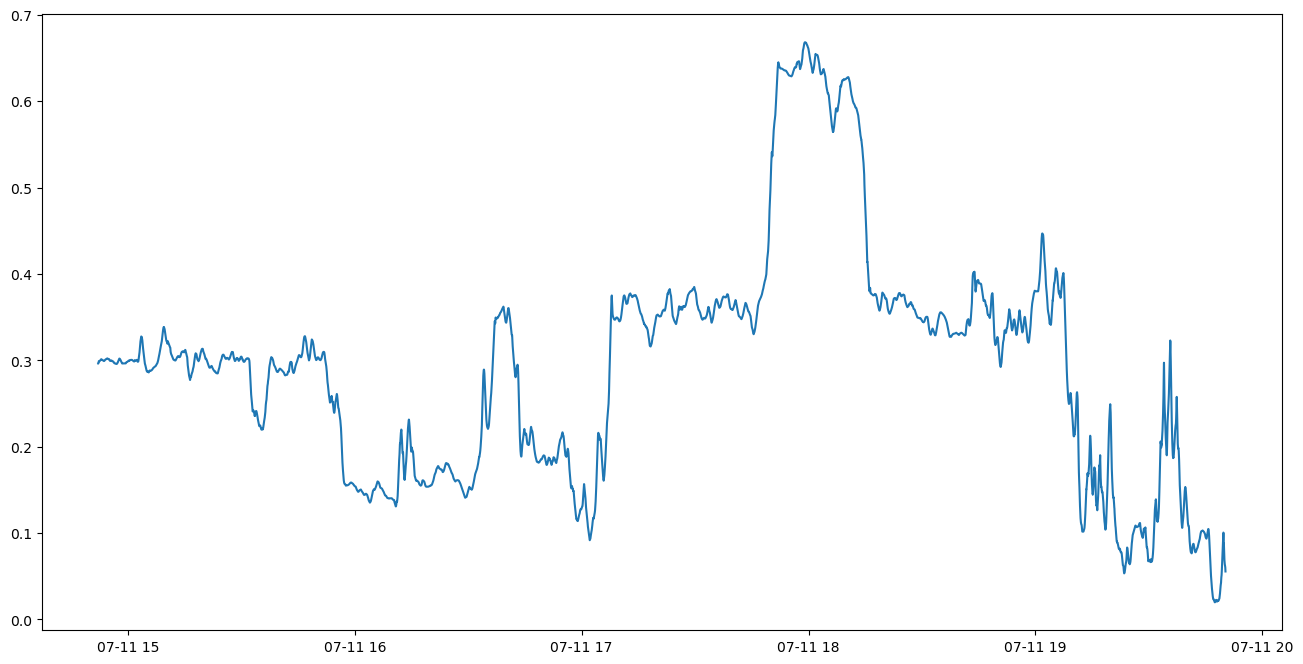

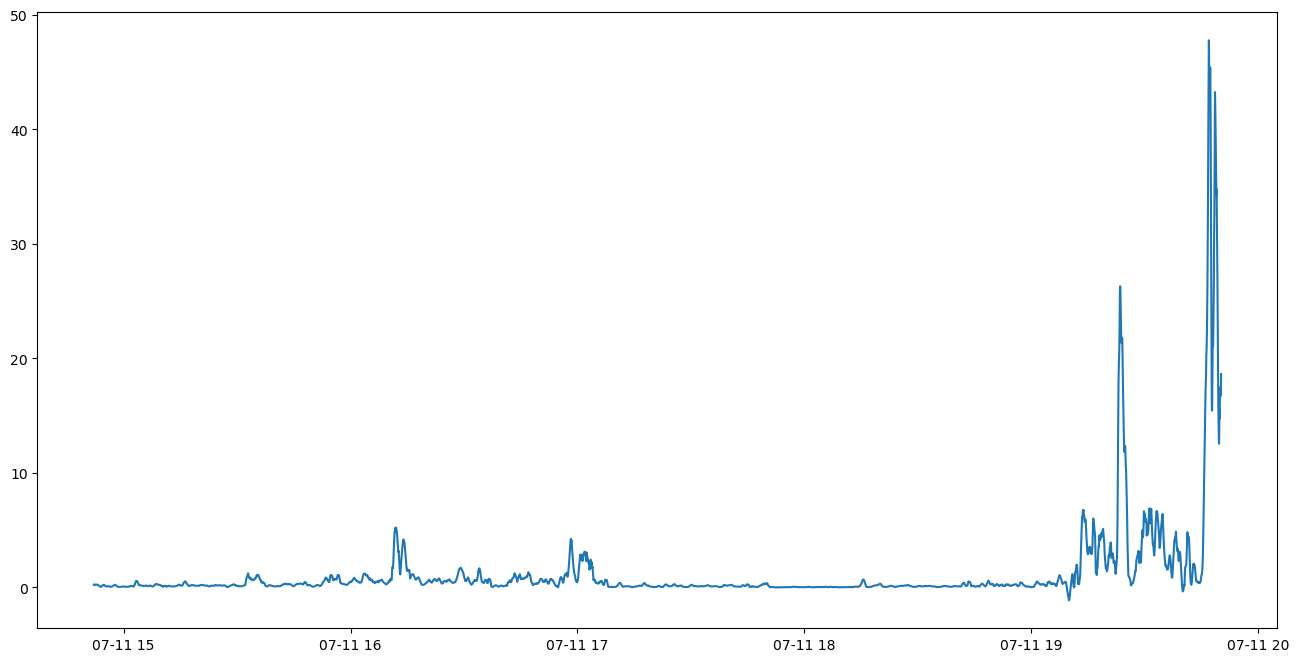

In [7]:
plt.figure(figsize=(16,8))
plt.plot(runner_1_best[['back','lay']])
plt.figure(figsize=(16,8))
plt.plot(1 / runner_1_best[['back-lay avg']])
plt.figure(figsize=(16,8))
plt.plot(runner_1_best[['spread']])